In [17]:
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from adam import ADAM
from iwls import IWLS
from sgd import SGD
import os

In [18]:
folder_path = 'datasets'
csv_files = glob.glob(folder_path + '/*.csv')
dfs = {}
file_names = []

for file in csv_files:
    file_name = Path(file).stem
    file_names.append(file_name)
    dfs[file_name] = pd.read_csv(file)

print(file_names)

['ajwa_or_medjool', 'fertility', 'mice_protein_expression', 'mushroom_classification', 'nhanes_survey_age_prediction', 'obesity_levels', 'room_occupancy_estimation', 'taiwanese_bankruptcy_prediction', 'wine_color_classification']


In [19]:
max_epochs = 500
tolerance = 1e-4
test_size = 0.3
n_samples = 1000
n_features = 70
batch_size = 16
standarize = True

In [20]:
Xs = {}
ys = {}

Xs_train = {}
Xs_test = {}
ys_train = {}
ys_test = {}

for file_name in file_names:
    Xs[file_name] = dfs[file_name].drop(columns=['target']).values
    ys[file_name] = dfs[file_name]['target'].values
    
    Xs_train[file_name], Xs_test[file_name], ys_train[file_name], ys_test[file_name] = train_test_split(Xs[file_name], ys[file_name], test_size=0.2, random_state=69)
    
    if standarize:
        scaler = StandardScaler()
        Xs_train[file_name] = scaler.fit_transform(Xs_train[file_name])
        Xs_test[file_name] = scaler.transform(Xs_test[file_name])

In [21]:
from main import run_custom_optimizer_experiment
from main import run_pytorch_experiment

Custom ADAM Accuracy: 0.8333333333333333
Custom IWLS Accuracy: 1.0
Custom SGD Accuracy: 1.0
PyTorch ADAM Accuracy: 0.0
PyTorch SGD Accuracy: 0.8333333333333333
Custom ADAM Accuracy: 0.5
Custom IWLS Accuracy: 0.47058823529411764
Custom SGD Accuracy: 0.5
PyTorch ADAM Accuracy: 0.6274509803921569
PyTorch SGD Accuracy: 0.5
Custom ADAM Accuracy: 0.9667764012821624
Custom IWLS Accuracy: 0.9719310404574201
Custom SGD Accuracy: 0.9625747206098935
PyTorch ADAM Accuracy: 0.882179675994109
PyTorch SGD Accuracy: 0.8863813566663779
Custom ADAM Accuracy: 1.0
Custom IWLS Accuracy: 1.0
Custom SGD Accuracy: 0.9993630573248408
PyTorch ADAM Accuracy: 0.995154686078253
PyTorch SGD Accuracy: 0.9974939338792842
Custom ADAM Accuracy: 0.9670281704327972
Custom IWLS Accuracy: 0.9746835443037974
Custom SGD Accuracy: 0.9670281704327972
PyTorch ADAM Accuracy: 0.8011449484605312
PyTorch SGD Accuracy: 0.9284491152670986
Custom ADAM Accuracy: 0.9902020202020202
Custom IWLS Accuracy: 0.9927272727272727
Custom SGD Acc

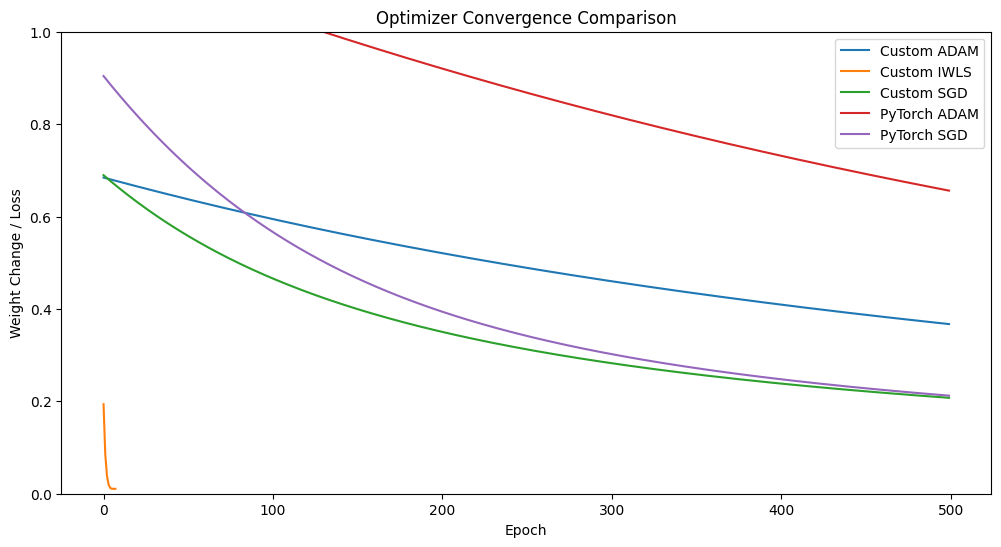

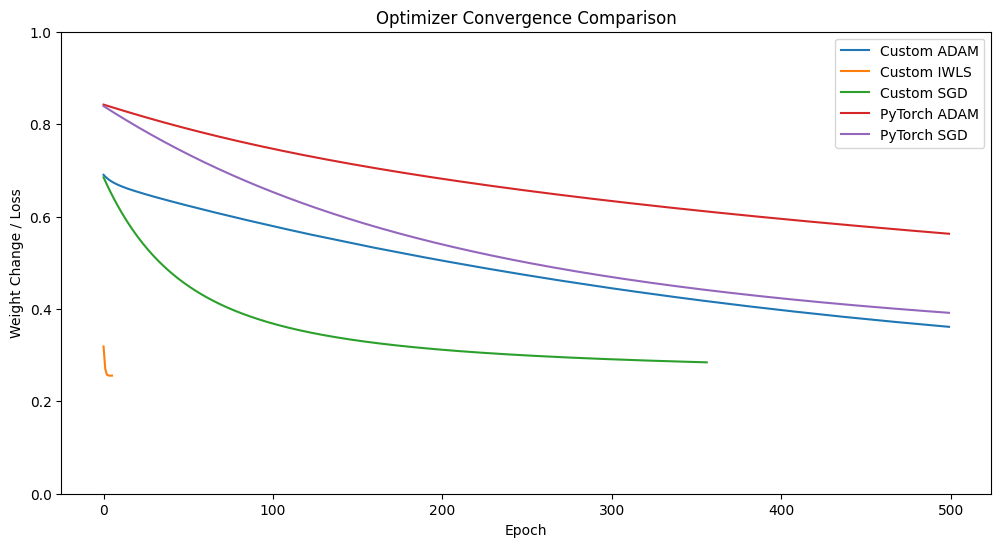

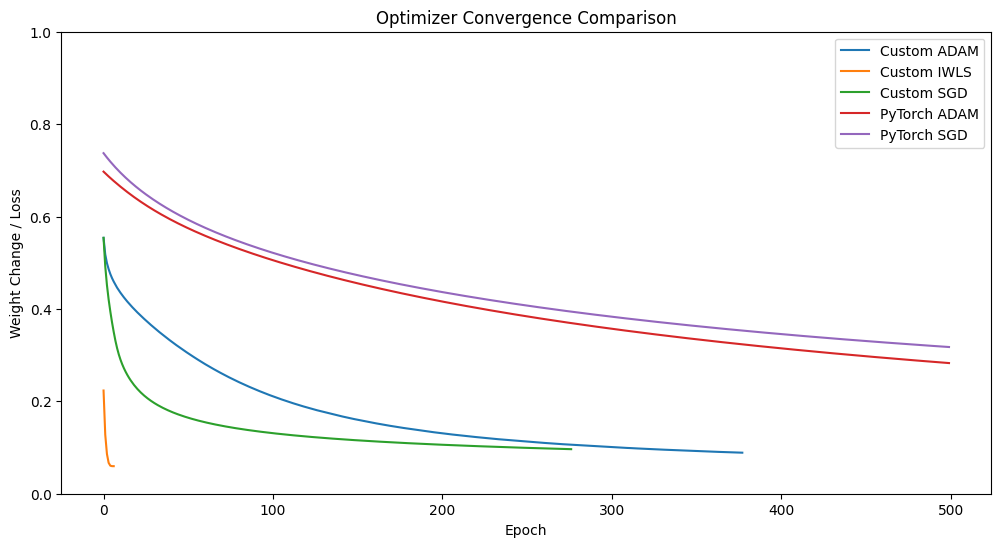

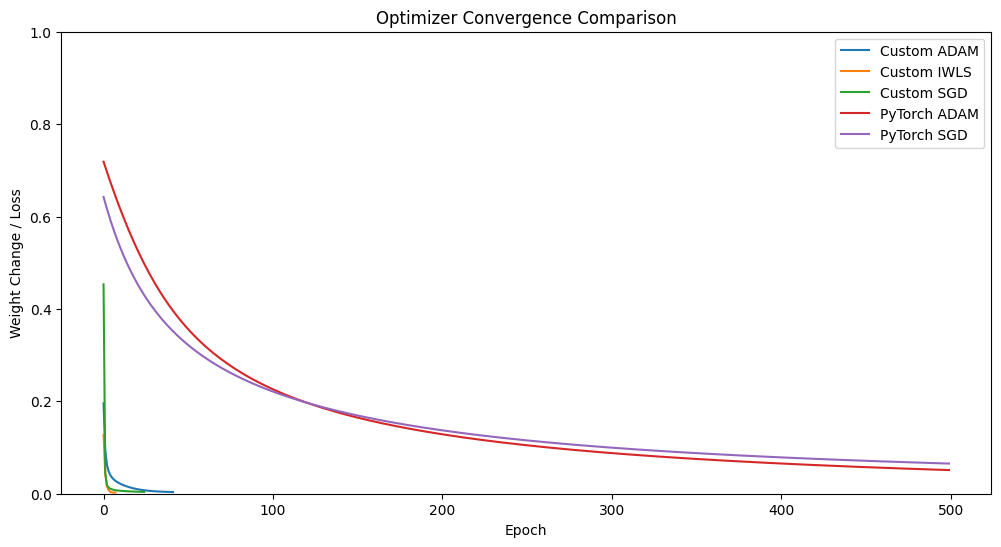

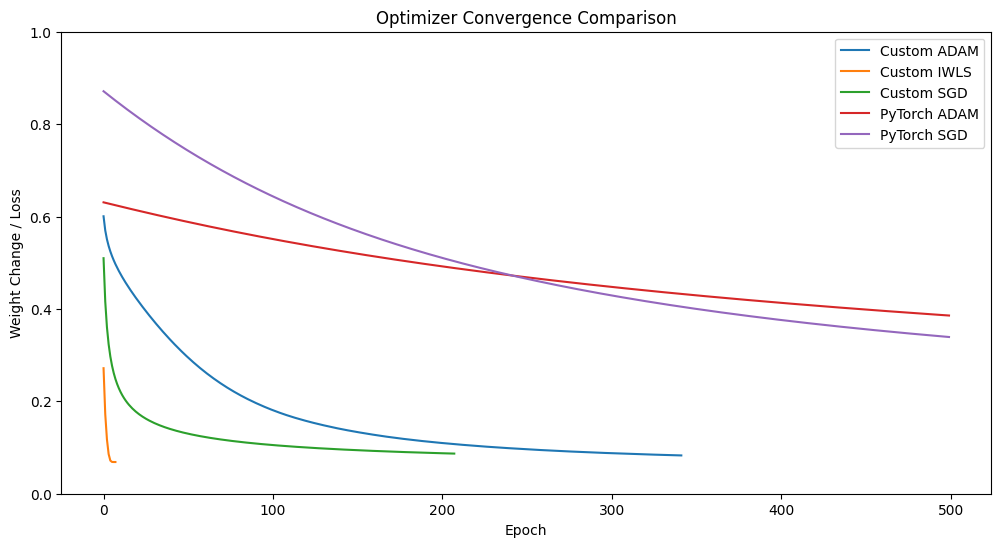

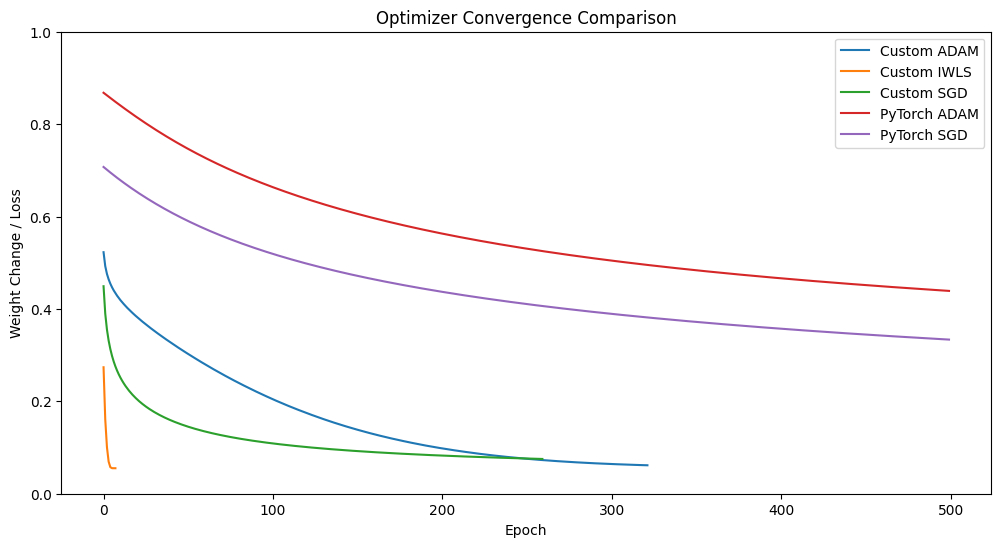

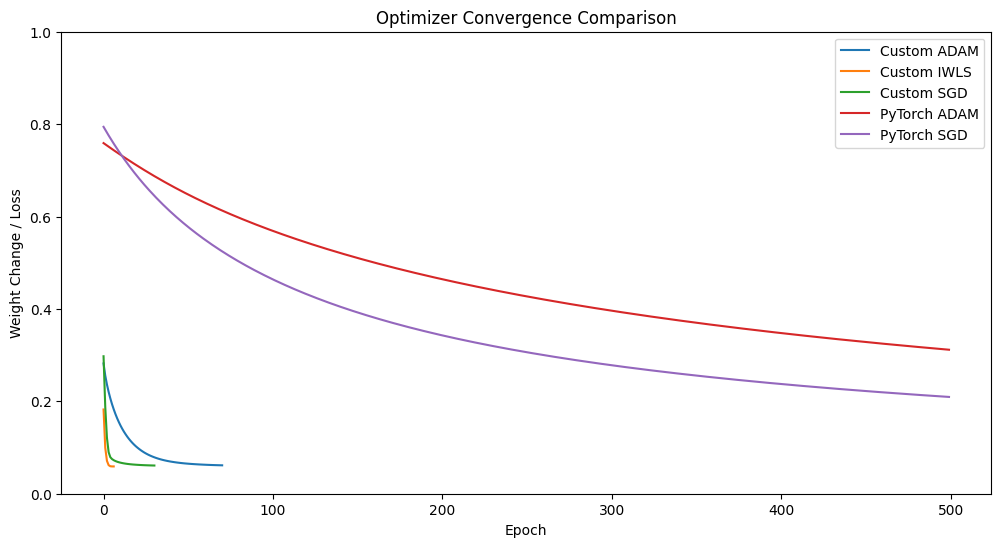

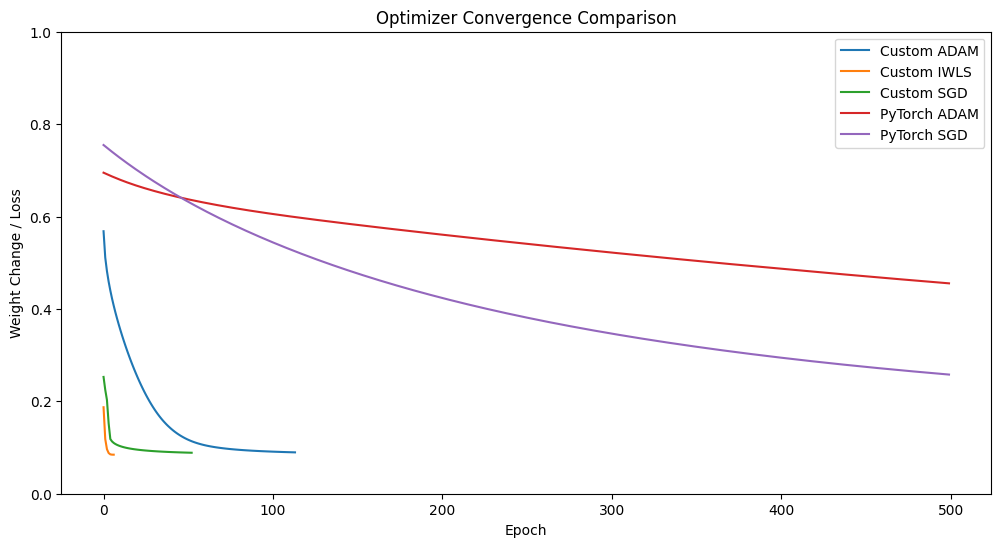

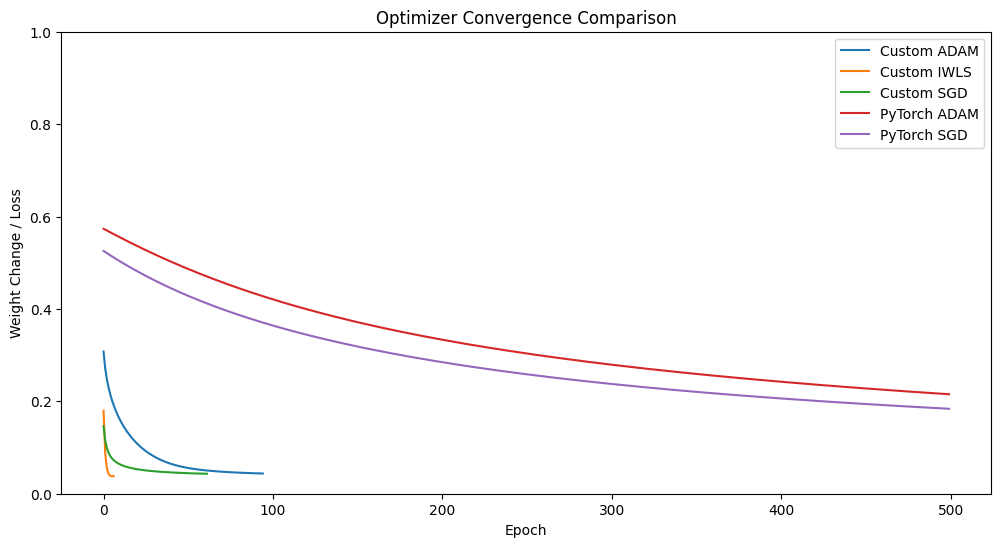

In [23]:
if not os.path.exists('outputs'):
    os.system('mkdir outputs')

for file_name in file_names:
    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    # Run experiments
    custom_adam_acc, adam_weight_changes = run_custom_optimizer_experiment(
        adam, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_iwls_acc, iwls_weight_changes = run_custom_optimizer_experiment(
        iwsl, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_sgd_acc, sgd_weight_changes = run_custom_optimizer_experiment(
        sgd, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )

    pytorch_adam_acc, pytorch_adam_losses = run_pytorch_experiment(
        Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], "adam", tolerance, max_epochs
    )
    pytorch_sgd_acc, pytorch_sgd_losses = run_pytorch_experiment(
        Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], "sgd", tolerance, max_epochs
    )

    # Print balanced accuracies
    print(f"Custom ADAM Accuracy: {custom_adam_acc}")
    print(f"Custom IWLS Accuracy: {custom_iwls_acc}")
    print(f"Custom SGD Accuracy: {custom_sgd_acc}")
    print(f"PyTorch ADAM Accuracy: {pytorch_adam_acc}")
    print(f"PyTorch SGD Accuracy: {pytorch_sgd_acc}")

    # Plot convergence
    plt.figure(figsize=(12, 6))

    plt.plot(adam_weight_changes, label="Custom ADAM")
    plt.plot(iwls_weight_changes, label="Custom IWLS")
    plt.plot(sgd_weight_changes, label="Custom SGD")
    plt.plot(pytorch_adam_losses, label="PyTorch ADAM")
    plt.plot(pytorch_sgd_losses, label="PyTorch SGD")

    plt.xlabel("Epoch")
    plt.ylabel("Weight Change / Loss")
    plt.ylim(0, 1)
    plt.title("Optimizer Convergence Comparison")
    plt.legend()
    
    plt.savefig(f"outputs/{file_name}_plot.pdf")

